In [1]:
import numpy as np
import os
import tensorflow as tf
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Loader

In [3]:
def load_model(model_name):
    cwd_path= os.getcwd()
    model_dir=os.path.join(cwd_path, model_name,'saved_model')
    print('{}'.format(model_dir))
    model=tf.saved_model.load(model_dir)
    return model


## Label_map Loading

In [4]:
label_path='object_detection/training/object_detection.pbtxt'
category_index=label_map_util.create_category_index_from_labelmap(label_path,use_display_name=True)

## Testing on one Image from testing images

In [5]:
test_img_dir=Path('object_detection/test_images')
test_img_paths=sorted(list(test_img_dir.glob("*.jpg")))

## Detection

In [6]:
model_name='frozen_model2'
detection_model=load_model(model_name)
##uncomment to check the model's input signature
#detection_model.signatures['serving_default'].inputs
#detection_model.signatures['serving_default'].output_dtypes
#detection_model.signatures['serving_default'].output_shapes

c:\Users\halak\OneDrive\Desktop\models\research\frozen_model2\saved_model


In [7]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                output_dict['detection_masks'], output_dict['detection_boxes'],
                image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
    return output_dict

In [8]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

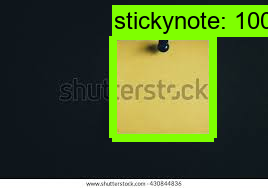

In [9]:
for img_path in test_img_paths:
    show_inference(detection_model, img_path)